In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root {--jp-notebook-max-width: 3000px;}</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display,HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 기계학습 (60점)

### 리그오브레전드 게임 로그 데이터
data_path = './data/game_result.csv'     
data_path = './data/log.csv'

데이터는 리그오브레전드 게임의 로그 데이터이다.    

---
리그오브 레전드 게임 룰
- 5명의 플레이어가 각자 다른 포지션에서 성장을 통해 아이템과 레벨을 올려 상대의 기지를 파괴하는 AOS장르의 게임
- 두 팀(red,blue)이 격돌, 각 팀은 5명의 플레이어가 5개의 포지션('T', 'J', 'M', 'B', 'S')을 하나씩 맡는다.   
---
데이터 설명
- game_result.csv : 게임 결과에 대한 정보
    - gameId: 게임명
    - win : 승리여부 True-승리, False-패배
    - TEAM: 팀 정보 (rea,blue)
    
- log.csv : 인게임 정보
    - time : 게임의 5분간격(~25분까지)
    - gameId : 게임명
    - variable : 6가지의 특정 행동 정보 
        - minionsKilled : 누적 몬스터 킬수
        - totalGold : 누적 골드획득량
        - totalDamageTaken : 누적 피해량
        - totalDamageDone : 누적 데미지
        - WARD_PLACED : 누적 시야 정보량
        - WARD_KILL : 누적 시야 제거량


In [3]:
import pandas as pd
gr =pd.read_csv('./data/game_result.csv')
display(gr.head())

log =pd.read_csv('./data/log.csv')
display(log.head())

,gameId,win,TEAM
0,JP1_340505476,False,blue
1,JP1_340505476,True,red
2,JP1_340611094,True,red
3,JP1_340611094,False,blue
4,JP1_340621330,True,red


,time,gameId,variable,value,POSITION,TEAM
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue


### 기계학습1
인게임 정보데이터는 5분간격의 누적 정보이다. each_variable 컬럼을 만들고 각 variable 별로 증가량값으로 채워넣어라      

<img src="./data/1.png" alt="alt_text" style="width:500px; float:left; ">

In [4]:
log2 = log.copy()
log2['each_variable'] = log2.groupby(['gameId', 'variable',  'POSITION', 'TEAM'])['value'].diff(1)
log2['each_variable'][log2['each_variable'].isna()] = log2['value']

In [5]:
log2

,time,gameId,variable,value,POSITION,TEAM,each_variable
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue,33.0
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue,43.0
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue,34.0
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue,33.0
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue,24.0
...,...,...,...,...,...,...,...
1059895,5.0,LA2_1170190226,WARD_KILL,0.0,S,red,0.0
1059896,10.0,LA2_1170190226,WARD_KILL,0.0,S,red,0.0
1059897,15.0,LA2_1170190226,WARD_KILL,2.0,S,red,2.0
1059898,20.0,LA2_1170190226,WARD_KILL,3.0,S,red,1.0


### 기계학습2
하나의 행에 하나의 인게임 정보를 넣는 작업을 하고 blue 팀의 승패유무와 관련한 데이터를 추가하려한다.     
아래의 전처리 조건을 확인하여 작업을 진행하라

변환할 데이터프레임의 컬럼정보
- gameId (게임아이디)
- {팀명}_{포지션}_{variable} 형식으로 컬럼을 추가한다. variable 별로 아래 조건을 만족하는 값을 채워 넣는다.
    - {팀명}_{포지션}_minionsKilled : 25분의 minionsKilled value컬럼 값을 추가한다.
    - {팀명}_{포지션}_totalGold : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageTaken : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.
    - {팀명}_{포지션}_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가한다.
    - {팀명}_{포지션}_WARD_KILL : each_variable의 max값을 추가한다.
- result : blue팀의 승리여부, 승리 : 1 , 패배 : 0 

아래와 같이 62개의 컬럼이 완성된다.    
<img src="./data/2.png" alt="alt_text" style="width:500px; float:left; ">

In [40]:
game = log2.groupby('gameId', as_index = False).count()[['gameId']]
for p in log2.POSITION.unique():
    game[f'blue_{p}_minionkilled'] = log2[(log2['TEAM'] == 'blue') & (log2['POSITION'] == p) & (log2['variable'] == 'minionsKilled')\
                                          & (log2['time'] == 25.0)].sort_values('gameId').reset_index()[['value']]
    game[f'red_{p}_minionkilled'] = log2[(log2['TEAM'] == 'red') & (log2['POSITION'] == p) & (log2['variable'] == 'minionsKilled')\
                                         & (log2['time'] == 25.0)].sort_values('gameId').reset_index()[['value']]
    game[f'blue_{p}_totalGold'] = log2[(log2['TEAM'] == 'blue') & (log2['POSITION'] == p)\
                                       & (log2['variable'] == 'totalGold')].groupby('gameId', as_index = False).mean()['each_variable']
    game[f'red_{p}_totalGold'] = log2[(log2['TEAM'] == 'red') & (log2['POSITION'] == p)\
                                      & (log2['variable'] == 'totalGold')].groupby('gameId', as_index = False).mean()['each_variable']
    game[f'blue_{p}_totalDamageTaken'] = log2[(log2['TEAM'] == 'blue') & (log2['POSITION'] == p) &\
                                              (log2['variable'] == 'totalDamageTaken')].groupby('gameId', as_index = False).mean()['each_variable']
    game[f'red_{p}_totalDamageTaken'] = log2[(log2['TEAM'] == 'red') & (log2['POSITION'] == p) &\
                                              (log2['variable'] == 'totalDamageTaken')].groupby('gameId', as_index = False).mean()['each_variable']
    game[f'blue_{p}_totalDamageDone'] = log2[(log2['TEAM'] == 'blue') & (log2['POSITION'] == p) &\
                                              (log2['variable'] == 'totalDamageDone')].groupby('gameId', as_index = False).mean()['each_variable']
    game[f'red_{p}_totalDamageDone'] = log2[(log2['TEAM'] == 'red') & (log2['POSITION'] == p) &\
                                              (log2['variable'] == 'totalDamageDone')].groupby('gameId', as_index = False).mean()['each_variable']
    game[f'blue_{p}_WARD_PLACED'] = log2[(log2['TEAM'] == 'blue') & (log2['POSITION'] == p) & (log2['variable'] == 'WARD_PLACED')\
                                          & (log2['time'] == 15.0)].sort_values('gameId').reset_index()[['value']]
    game[f'red{p}_WARD_PLACED'] = log2[(log2['TEAM'] == 'red') & (log2['POSITION'] == p) & (log2['variable'] == 'WARD_PLACED')\
                                          & (log2['time'] == 15.0)].sort_values('gameId').reset_index()[['value']]
    game[f'blue_{p}_WARD_KILL'] = log2[(log2['TEAM'] == 'blue') & (log2['POSITION'] == p)\
                                       & (log2['variable'] == 'WARD_KILL')].groupby('gameId', as_index = False).max()['each_variable']
    game[f'red_{p}_WARD_KILL'] = log2[(log2['TEAM'] == 'red') & (log2['POSITION'] == p)\
                                      & (log2['variable'] == 'WARD_KILL')].groupby('gameId', as_index = False).max()['each_variable']
    
game['result'] = gr[gr['TEAM'] == 'blue'].sort_values('gameId').reset_index()[['win']].astype('int')
game

,gameId,blue_T_minionkilled,red_T_minionkilled,blue_T_totalGold,red_T_totalGold,blue_T_totalDamageTaken,red_T_totalDamageTaken,blue_T_totalDamageDone,red_T_totalDamageDone,blue_T_WARD_PLACED,redT_WARD_PLACED,blue_T_WARD_KILL,red_T_WARD_KILL,blue_J_minionkilled,red_J_minionkilled,blue_J_totalGold,red_J_totalGold,blue_J_totalDamageTaken,red_J_totalDamageTaken,blue_J_totalDamageDone,red_J_totalDamageDone,blue_J_WARD_PLACED,redJ_WARD_PLACED,blue_J_WARD_KILL,red_J_WARD_KILL,blue_M_minionkilled,red_M_minionkilled,blue_M_totalGold,red_M_totalGold,blue_M_totalDamageTaken,red_M_totalDamageTaken,blue_M_totalDamageDone,red_M_totalDamageDone,blue_M_WARD_PLACED,redM_WARD_PLACED,blue_M_WARD_KILL,red_M_WARD_KILL,blue_B_minionkilled,red_B_minionkilled,blue_B_totalGold,red_B_totalGold,blue_B_totalDamageTaken,red_B_totalDamageTaken,blue_B_totalDamageDone,red_B_totalDamageDone,blue_B_WARD_PLACED,redB_WARD_PLACED,blue_B_WARD_KILL,red_B_WARD_KILL,blue_S_minionkilled,red_S_minionkilled,blue_S_totalGold,red_S_totalGold,blue_S_totalDamageTaken,red_S_totalDamageTaken,blue_S_totalDamageDone,red_S_totalDamageDone,blue_S_WARD_PLACED,redS_WARD_PLACED,blue_S_WARD_KILL,red_S_WARD_KILL,result
0,JP1_340505476,188.0,173.0,2291.2,1841.0,4372.2,3102.2,24196.4,19730.8,12.0,17.0,4.0,2.0,14.0,22.0,1890.8,2161.8,4871.6,5060.4,26591.6,26047.0,3.0,1.0,1.0,1.0,140.0,167.0,1702.4,2016.6,3237.8,3745.8,14987.2,20783.0,3.0,5.0,2.0,1.0,54.0,168.0,1432.0,2879.6,2925.4,2585.2,4439.2,31681.2,9.0,22.0,6.0,1.0,168.0,52.0,2243.0,3062.4,3195.6,2245.2,21754.6,10134.2,7.0,6.0,4.0,8.0,0
1,JP1_340611094,169.0,155.0,1661.6,2378.2,2947.0,4893.4,21479.0,23852.4,5.0,4.0,2.0,1.0,28.0,48.0,1978.4,2288.6,5371.0,4318.2,22019.2,35338.4,2.0,1.0,4.0,6.0,197.0,148.0,2382.4,2017.2,4497.0,3786.6,30324.6,19504.8,5.0,5.0,2.0,2.0,181.0,194.0,1832.8,2563.8,3372.8,2293.0,19481.0,33487.2,4.0,7.0,2.0,2.0,26.0,17.0,1265.6,1694.2,3163.4,2010.8,4797.4,6067.8,14.0,129.0,2.0,5.0,0
2,JP1_340621330,97.0,183.0,1482.4,2385.0,4410.6,3999.8,10838.8,22448.8,0.0,69.0,0.0,1.0,61.0,15.0,1921.6,1866.4,3991.2,3605.2,28254.6,25402.0,3.0,7.0,2.0,4.0,202.0,147.0,1800.6,2002.0,3072.0,3347.0,23513.2,20998.6,4.0,5.0,2.0,0.0,192.0,189.0,1531.4,2085.0,1974.2,2101.0,19557.4,25039.6,5.0,4.0,2.0,0.0,37.0,24.0,1058.0,1344.6,1247.4,1393.6,3461.6,3468.0,11.0,7.0,6.0,2.0,0
3,JP1_340652067,191.0,148.0,2130.0,1784.0,2735.2,2639.2,22162.4,16056.4,6.0,5.0,5.0,2.0,68.0,22.0,1949.0,1849.0,3352.4,3933.4,32217.2,24810.2,5.0,4.0,4.0,2.0,166.0,177.0,1454.6,2007.2,2368.4,2013.0,17718.4,22906.0,6.0,2.0,0.0,2.0,203.0,217.0,2060.0,2088.0,2049.4,2235.0,28396.6,29142.4,7.0,5.0,1.0,3.0,36.0,34.0,1166.0,1280.4,1578.6,1714.4,3139.8,3412.2,11.0,7.0,4.0,3.0,0
4,JP1_341114767,196.0,182.0,2406.2,1778.0,3379.0,4593.8,36909.8,22784.0,49.0,0.0,0.0,9.0,21.0,40.0,2414.0,2291.2,5589.4,6912.4,24121.2,27748.0,4.0,1.0,3.0,1.0,192.0,173.0,2732.2,2208.6,4417.0,3409.6,37150.4,28975.8,4.0,4.0,1.0,3.0,123.0,207.0,2048.2,2279.0,3189.8,3515.4,18039.8,27718.4,6.0,6.0,2.0,2.0,33.0,8.0,1478.4,1159.8,3326.0,2363.2,4183.4,6015.8,12.0,8.0,2.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,NA1_4298502759,156.0,191.0,1950.2,2427.6,4118.4,3024.4,22424.8,20201.2,4.0,9.0,1.0,1.0,17.0,15.0,1901.4,2468.2,5064.0,5331.4,25309.2,37816.4,6.0,3.0,1.0,3.0,165.0,146.0,2442.6,1823.2,4189.4,4306.0,11146.2,15013.4,2.0,9.0,6.0,2.0,166.0,139.0,2167.4,1594.4,3798.0,2843.8,17811.8,13427.0,5.0,6.0,0.0,1.0,42.0,17.0,1282.0,2040.8,1995.2,2490.4,3236.6,7848.0,13.0,10.0,1.0,5.0,0
3371,NA1_4298524350,147.0,207.0,1699.2,1824.0,2620.4,4869.8,11298.8,22546.2,4.0,6.0,2.0,1.0,149.0,45.0,2923.8,2419.0,4400.6,4611.6,29214.4,30535.6,6.0,2.0,3.0,0.0,56.0,130.0,2317.0,2171.2,3998.2,2619.6,11788.2,19613.2,3.0,6.0,0.0,2.0,144.0,155.0,1535.6,1589.8,3894.6,1852.4,17995.4,10258.8,3.0,6.0,2.0,0.0,42.0,16.0,1057

### 기계학습 3
데이터 EDA 및 시각화

In [45]:
data = game.drop('gameId', axis = 1)
data

,blue_T_minionkilled,red_T_minionkilled,blue_T_totalGold,red_T_totalGold,blue_T_totalDamageTaken,red_T_totalDamageTaken,blue_T_totalDamageDone,red_T_totalDamageDone,blue_T_WARD_PLACED,redT_WARD_PLACED,blue_T_WARD_KILL,red_T_WARD_KILL,blue_J_minionkilled,red_J_minionkilled,blue_J_totalGold,red_J_totalGold,blue_J_totalDamageTaken,red_J_totalDamageTaken,blue_J_totalDamageDone,red_J_totalDamageDone,blue_J_WARD_PLACED,redJ_WARD_PLACED,blue_J_WARD_KILL,red_J_WARD_KILL,blue_M_minionkilled,red_M_minionkilled,blue_M_totalGold,red_M_totalGold,blue_M_totalDamageTaken,red_M_totalDamageTaken,blue_M_totalDamageDone,red_M_totalDamageDone,blue_M_WARD_PLACED,redM_WARD_PLACED,blue_M_WARD_KILL,red_M_WARD_KILL,blue_B_minionkilled,red_B_minionkilled,blue_B_totalGold,red_B_totalGold,blue_B_totalDamageTaken,red_B_totalDamageTaken,blue_B_totalDamageDone,red_B_totalDamageDone,blue_B_WARD_PLACED,redB_WARD_PLACED,blue_B_WARD_KILL,red_B_WARD_KILL,blue_S_minionkilled,red_S_minionkilled,blue_S_totalGold,red_S_totalGold,blue_S_totalDamageTaken,red_S_totalDamageTaken,blue_S_totalDamageDone,red_S_totalDamageDone,blue_S_WARD_PLACED,redS_WARD_PLACED,blue_S_WARD_KILL,red_S_WARD_KILL,result
0,188.0,173.0,2291.2,1841.0,4372.2,3102.2,24196.4,19730.8,12.0,17.0,4.0,2.0,14.0,22.0,1890.8,2161.8,4871.6,5060.4,26591.6,26047.0,3.0,1.0,1.0,1.0,140.0,167.0,1702.4,2016.6,3237.8,3745.8,14987.2,20783.0,3.0,5.0,2.0,1.0,54.0,168.0,1432.0,2879.6,2925.4,2585.2,4439.2,31681.2,9.0,22.0,6.0,1.0,168.0,52.0,2243.0,3062.4,3195.6,2245.2,21754.6,10134.2,7.0,6.0,4.0,8.0,0
1,169.0,155.0,1661.6,2378.2,2947.0,4893.4,21479.0,23852.4,5.0,4.0,2.0,1.0,28.0,48.0,1978.4,2288.6,5371.0,4318.2,22019.2,35338.4,2.0,1.0,4.0,6.0,197.0,148.0,2382.4,2017.2,4497.0,3786.6,30324.6,19504.8,5.0,5.0,2.0,2.0,181.0,194.0,1832.8,2563.8,3372.8,2293.0,19481.0,33487.2,4.0,7.0,2.0,2.0,26.0,17.0,1265.6,1694.2,3163.4,2010.8,4797.4,6067.8,14.0,129.0,2.0,5.0,0
2,97.0,183.0,1482.4,2385.0,4410.6,3999.8,10838.8,22448.8,0.0,69.0,0.0,1.0,61.0,15.0,1921.6,1866.4,3991.2,3605.2,28254.6,25402.0,3.0,7.0,2.0,4.0,202.0,147.0,1800.6,2002.0,3072.0,3347.0,23513.2,20998.6,4.0,5.0,2.0,0.0,192.0,189.0,1531.4,2085.0,1974.2,2101.0,19557.4,25039.6,5.0,4.0,2.0,0.0,37.0,24.0,1058.0,1344.6,1247.4,1393.6,3461.6,3468.0,11.0,7.0,6.0,2.0,0
3,191.0,148.0,2130.0,1784.0,2735.2,2639.2,22162.4,16056.4,6.0,5.0,5.0,2.0,68.0,22.0,1949.0,1849.0,3352.4,3933.4,32217.2,24810.2,5.0,4.0,4.0,2.0,166.0,177.0,1454.6,2007.2,2368.4,2013.0,17718.4,22906.0,6.0,2.0,0.0,2.0,203.0,217.0,2060.0,2088.0,2049.4,2235.0,28396.6,29142.4,7.0,5.0,1.0,3.0,36.0,34.0,1166.0,1280.4,1578.6,1714.4,3139.8,3412.2,11.0,7.0,4.0,3.0,0
4,196.0,182.0,2406.2,1778.0,3379.0,4593.8,36909.8,22784.0,49.0,0.0,0.0,9.0,21.0,40.0,2414.0,2291.2,5589.4,6912.4,24121.2,27748.0,4.0,1.0,3.0,1.0,192.0,173.0,2732.2,2208.6,4417.0,3409.6,37150.4,28975.8,4.0,4.0,1.0,3.0,123.0,207.0,2048.2,2279.0,3189.8,3515.4,18039.8,27718.4,6.0,6.0,2.0,2.0,33.0,8.0,1478.4,1159.8,3326.0,2363.2,4183.4,6015.8,12.0,8.0,2.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,156.0,191.0,1950.2,2427.6,4118.4,3024.4,22424.8,20201.2,4.0,9.0,1.0,1.0,17.0,15.0,1901.4,2468.2,5064.0,5331.4,25309.2,37816.4,6.0,3.0,1.0,3.0,165.0,146.0,2442.6,1823.2,4189.4,4306.0,11146.2,15013.4,2.0,9.0,6.0,2.0,166.0,139.0,2167.4,1594.4,3798.0,2843.8,17811.8,13427.0,5.0,6.0,0.0,1.0,42.0,17.0,1282.0,2040.8,1995.2,2490.4,3236.6,7848.0,13.0,10.0,1.0,5.0,0
3371,147.0,207.0,1699.2,1824.0,2620.4,4869.8,11298.8,22546.2,4.0,6.0,2.0,1.0,149.0,45.0,2923.8,2419.0,4400.6,4611.6,29214.4,30535.6,6.0,2.0,3.0,0.0,56.0,130.0,2317.0,2171.2,3998.2,2619.6,11788.2,19613.2,3.0,6.0,0.0,2.0,144.0,155.0,1535.6,1589.8,3894.6,1852.4,17995.4,10258.8,3.0,6.0,2.0,0.0,42.0,16.0,1057.2,1341.4,1458.0,2490.6,786.6,3499.2,4.0,53.0,0.0,0.0,0
3372,207.0,174.0,1721.8,2350.0,4188.8,3751.8,20369.0,35

In [78]:
#plt.figure(figsize = (20,10))
sns.hist(data = data, x = 'blue_T_minionkilled', hue = 'reulst')

AttributeError: module 'seaborn' has no attribute 'histplot'

### 기계학습4      
전처리한 데이터를 바탕으로 승리 예측 분류 모델을 만들려고한다. 아래의 기준으로 모델링을 하고 평가를 진행하라     
- 랜덤포레스트와 그래디언트 부스팅으로 학습한다
- 각 모델별로 3개의 파라미터들을 2개 이상 조합하여 최적의 파라미터를 찾는다.   
- 학습데이터는 70%를 사용한다
- auc값으로 평가를 진행하며 ROC Curve를 그려라

In [79]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve

AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

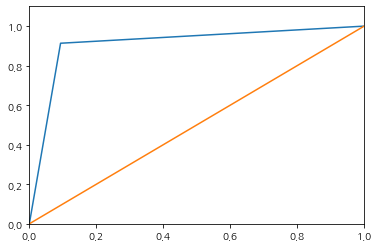

In [82]:
x = data.drop('result', axis = 1)
y = data[['result']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 47)

param_rf = {'n_estimators':[50, 100], 'criterion':['gini','entropy'], 'max_depth':[5,10,None]}
param_gb = {'loss':['deviance', 'exponential'], 'learning_rate':[0.05, 0.1, 0.2], 'n_estimators':[50, 100]}

grid_rf = GridSearchCV(RandomForestClassifier(random_state = 47), param_grid = param_rf)
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state = 50), param_grid = param_gb)

grid_rf.fit(x_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict_proba(x_test)

grid_gb.fit(x_train, y_train)
best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict_proba(x_test)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)

plt.plot(fpr_rf, tpr_rf, label = f'roc_auc_score:{auc_rf:.2f}')
plt.plot([0,1], [0,1])
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.label()
plt.show()

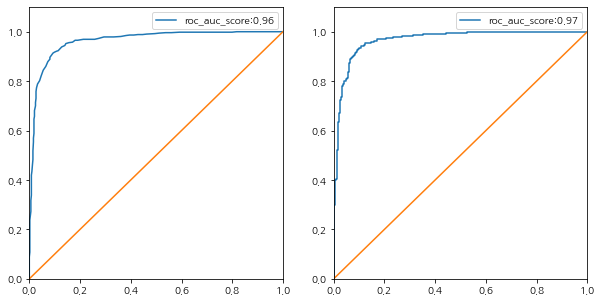

In [95]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf[:,1])
auc_rf = roc_auc_score(y_test, y_pred_rf[:,1])

fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_gb[:,1])
auc_gb = roc_auc_score(y_test, y_pred_gb[:,1])


plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(fpr_rf, tpr_rf, label = f'roc_auc_score:{auc_rf:.2f}')
plt.plot([0,1], [0,1])
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.legend()
plt.subplot(122)
plt.plot(fpr_gb, tpr_gb, label = f'roc_auc_score:{auc_gb:.2f}')
plt.plot([0,1], [0,1])
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.legend()
plt.show()


### 기계학습5 
성능이 우수한 모델로부터 변수중요도를 시각화하고 해석하라

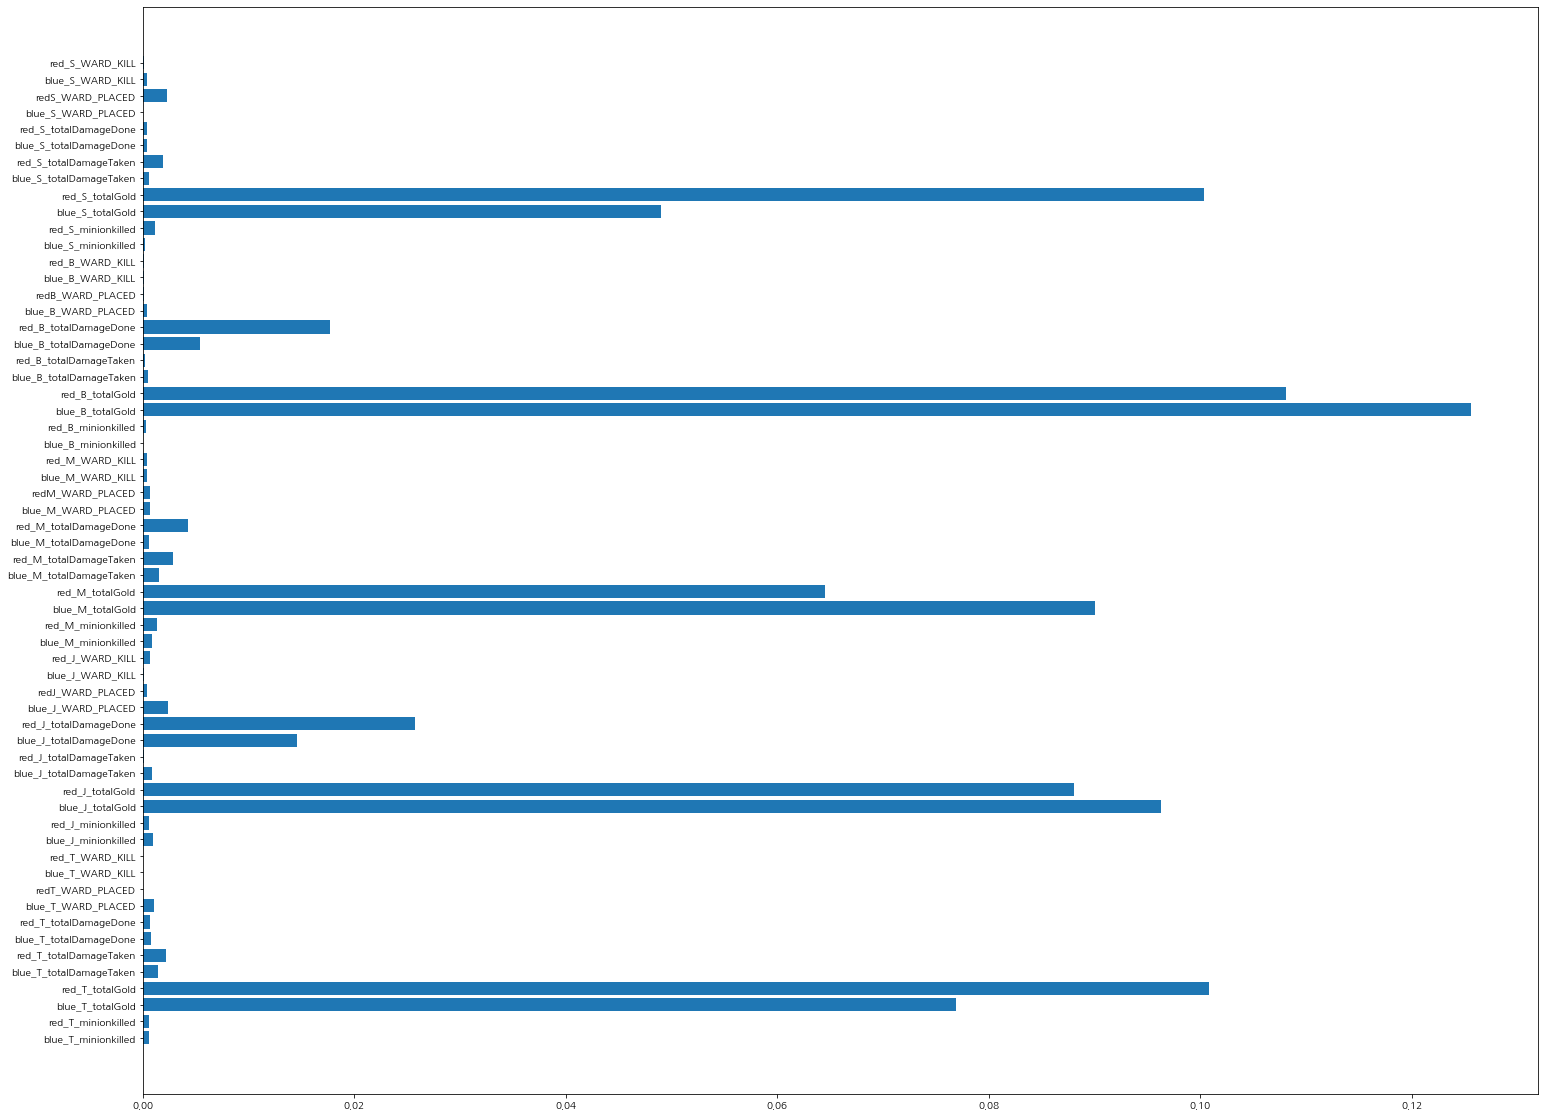

In [120]:
df = pd.DataFrame(best_gb.feature_importances_, columns = ['importance'])
df['feature_name'] = x.columns

plt.figure(figsize = (25,20))
plt.barh(df['feature_name'], df['importance'])
plt.show()

### 폐처리 시설의 여러 대기 측정정보

data_path = './data/mc.csv'

데이터는 특정 폐수 처리시설 주변의 여러 측정센서를 통해 5분간격으로 측정한 데이터이다.
- 매 5분동안 최대 24개의 주변 측정소에서 여러 정보들을 수집한다. 

In [121]:
import pandas as pd
df = pd.read_csv('./data/mc.csv')
df.head()

,측정장소,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
0,1,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
1,3,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,9.2,0.0,0.0,0,0.0,0.0
2,4,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.8,0.0,0.0,0,0.0,0.0
3,5,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
4,6,2022-01-10 09:00:00,12.14,81.9,0.3,0.03,6.0,0.0,0.0,0,1019.5,113.8


### 기계학습5    
다음의 기준으로 전처리를 시행하고 시각화를 포함한 EDA를 진행하라
1. 측정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만 남겨라. 
2. 1의 전처리 후 온도 ~ 초미세먼지 값이 모두 0인 데이터 행은 제거하라

In [132]:
df2 = df.drop('측정장소', axis = 1).groupby('측정일시', as_index = False).max()
df2 = df2.loc[df2.sum(axis = 1) != 0].reset_index(drop = True)

In [135]:
df2.describe()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
count,40364.000000,40364.000000,40364.000000,40364.000000,40364.000000,40364.000000,40364.000000,40364.0,40364.000000,40364.000000
mean,20.490898,61.882341,0.920166,0.266473,12.901856,36.746058,704.024581,0.0,922.426700,206.302254
std,4.507456,21.518572,0.270590,0.181363,5.876157,106.397281,1981.774919,0.0,298.034458,370.841189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,16.677500,50.530000,1.000000,0.140000,9.000000,5.000000,107.000000,0.0,1012.000000,17.000000
50%,20.330000,63.200000,1.000000,0.240000,14.400000,11.000000,174.700000,0.0,1017.700000,31.000000
75%,24.000000,78.170000,1.000000,0.370000,17.600000,24.000000,225.000000,0.0,1023.500000,65.000000
max,55.440000,100.000000,1.000000,1.400000,20.000000,1000.000000,18644.200000,0.0,1036.000000,985.000000


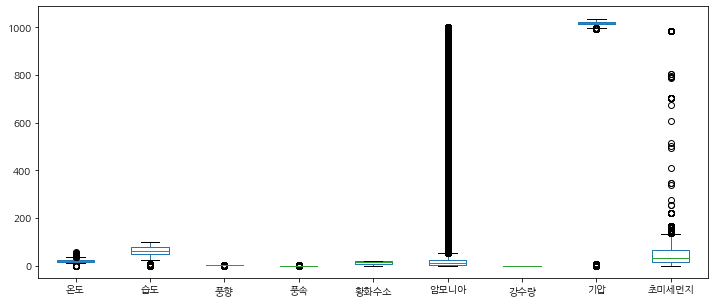

In [134]:
df2.drop('휘발성유기화합물', axis = 1).plot(kind = 'box', figsize = (12,5))

### 기계학습6     
데이터의 측정시간대를 일별 6시간 간격(0 ~ 5시 ,6~12시 ..)으로 나누어 각 컬럼의 수치 평균값을 내라. 
각 시간 구간을 0,1,2,3으로 표기하고 date_split 컬럼을 추가한다.

In [137]:
df2['측정일시'] = pd.to_datetime(df2['측정일시'])
df2.dtypes

측정일시        datetime64[ns]
온도                 float64
습도                 float64
풍향                 float64
풍속                 float64
황화수소               float64
암모니아               float64
휘발성유기화합물           float64
강수량                  int64
기압                 float64
초미세먼지              float64
dtype: object

In [139]:
df2['date_split'] = df2.측정일시.apply(lambda x : x.hour//6)

In [142]:
df2.groupby('date_split').mean().T

date_split,0,1,2,3
온도,19.126401,20.663905,22.305817,19.865287
습도,69.820901,61.973266,51.730485,64.029254
풍향,0.919857,0.920474,0.921526,0.918815
풍속,0.179624,0.234525,0.399507,0.251769
황화수소,14.147446,12.297990,11.160184,13.999310
암모니아,22.089773,30.679407,53.691182,40.416470
휘발성유기화합물,1095.190737,881.189087,313.207611,529.772975
강수량,0.000000,0.000000,0.000000,0.000000
기압,920.996830,921.539455,924.846586,922.313887
초미세먼지,202.418843,220.300726,207.866152,194.727311


### 기계학습7     
5번에서 전처리한 데이터의 변수간 상관관계를 확인하라.    
date_split의 값이 2과 3인 데이터만 필터하고 각 온도~초미세먼지의 컬럼이 date_split 값에 따른 차이가 존재하는지 통계검정하라

In [146]:
df2.drop(['측정일시', 'date_split', '강수량'], axis = 1).corr()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,기압,초미세먼지
온도,1.000000,0.262709,0.308983,0.310996,-0.102327,0.354944,0.045560,0.347367,0.258328
습도,0.262709,1.000000,0.409337,0.056882,0.388124,0.078465,0.359727,0.532055,0.239970
풍향,0.308983,0.409337,1.000000,0.429180,0.598564,0.101549,0.102530,0.889619,0.162925
풍속,0.310996,0.056882,0.429180,1.000000,0.173633,0.157059,-0.030827,0.471199,0.049342
황화수소,-0.102327,0.388124,0.598564,0.173633,1.000000,-0.064714,0.088153,0.614410,0.044666
암모니아,0.354944,0.078465,0.101549,0.157059,-0.064714,1.000000,0.001710,0.103861,0.012121
휘발성유기화합물,0.045560,0.359727,0.102530,-0.030827,0.088153,0.001710,1.000000,0.107489,0.092169
기압,0.347367,0.532055,0.889619,0.471199,0.614410,0.103861,0.107489,1.000000,0.175086
초미세먼지,0.258328,0.239970,0.162925,0.049342,0.044666,0.012121,0.092169,0.175086,1.000000


In [147]:
from scipy.stats import mannwhitneyu

In [163]:
f = df2[df2.date_split.isin([2,3])].drop(['측정일시', '강수량'], axis = 1)

l = []

for i in f.columns[:-1]:
    three = f[i][f['date_split'] == 3]
    two = f[i][f['date_split'] == 2]
    stat, p = mannwhitneyu(three, two)
    l.append([stat, p])
    
f_result = pd.DataFrame(l, columns =['검정통계량', 'p-value'])
f_result['변수'] = f.columns[:-1]
f_result

,검정통계량,p-value,변수
0,36343028.0,4.055807e-282,온도
1,29329493.0,0.000000e+00,습도
2,51086632.5,1.916770e-01,풍향
3,27476431.5,0.000000e+00,풍속
4,36954696.0,1.195869e-259,황화수소
5,33579469.5,0.000000e+00,암모니아
6,46325886.0,9.370727e-33,휘발성유기화합물
7,49331642.5,1.812223e-06,기압
8,51182316.5,4.279382e-01,초미세먼지


### 기계학습 8
전처리한 데이터를 바탕으로 초미세먼지를 예측하는 모델을 만들려고한다.     
적절한 변수 처리를 하고 다중선형회귀, 랜덤포레스트 모델을 통해 모델 평가를 실시하라.
rmse로 평가를 진행한다. 

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [162]:
df3 = df2.drop(['측정일시', '강수량', 'date_split'], axis = 1)
#df3 = f.drop(['date_split'], axis = 1)

x = df3.drop('초미세먼지', axis = 1)
x['휘발성유기화합물'] = np.log1p(x['휘발성유기화합물'])
y = df3['초미세먼지']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 35)

rf = RandomForestRegressor(random_state = 35)
lr = LinearRegression()

rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print(f'랜포 rmse:{np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}')

lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
print(f'회귀 rmse:{np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}')

랜포 rmse:123.41
회귀 rmse:346.56


# 통계 (40점)

## 통계1

### 통계1-1      
어느 지역의 미세 지진 발생 간격은 평균 10년이다. 이 지진 발생 간격은 지수 분포를 따른다고 가정한다.      
최근 지진 이후 5년이 지난 시점에서 7년 이내에 지진이 발생하지 않을 확률은?     

In [173]:
from scipy.stats import expon
exp = expon(scale = 10)

In [175]:
1 - exp.cdf(7)

0.4965853037914095

### 통계 1-2
지난 지진 발생 후 15년이 지났다. 8년 이내에 지진이 발생할 확률은?

In [176]:
exp.cdf(8)

0.5506710358827784

## 통계2
data_path = './data/s1.csv'     
데이터는 식단과 운동강도에 따라 감량 체중을 기록한 다이어트 프로그램 결과이다. 

In [1]:
import pandas as pd
df =pd.read_csv('./data/s1.csv')
df.head()

,유저,식단,운동,감량체중
0,ID-1,저탄고단,저강도,5.496714
1,ID-2,저탄고단,저강도,4.861736
2,ID-3,저탄고단,저강도,5.647689
3,ID-4,저탄고단,저강도,6.523030
4,ID-5,저탄고단,저강도,4.765847


### 통계 2-1
식단과 운동의 조합으로 만들어지는 4개의 그룹들의 각 그룹의 정규성과 그룹간 등분산성을 확인하라    

In [179]:
from scipy.stats import shapiro, levene

In [181]:
df.식단.unique()

array(['저탄고단', '저탄고지'], dtype=object)

In [182]:
df.운동.unique()

array(['저강도', '고강도'], dtype=object)

In [190]:
df1 = df[(df['식단'] == '저탄고단') & (df['운동'] == '저강도')]['감량체중']
df2 = df[(df['식단'] == '저탄고지') & (df['운동'] == '저강도')]['감량체중']
df3 = df[(df['식단'] == '저탄고단') & (df['운동'] == '고강도')]['감량체중']
df4 = df[(df['식단'] == '저탄고지') & (df['운동'] == '고강도')]['감량체중']

print(shapiro(df1)[1])
print(shapiro(df2)[1])
print(shapiro(df3)[1])
print(shapiro(df4)[1])
print(levene(df1,df2,df3,df4)[1])

0.6603962779045105
0.3268723487854004
0.370868057012558
0.16240304708480835
0.5736005994381785


### 통계 2-2
이원분산분석을 진행하려한다. 2-1의 결과를 바탕으로 모수,비모수 방법을 결정하고 주효과에 대한 가설과 교호작용 효과에 대한 가설을 설정하라    

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [9]:
model = ols('감량체중~C(식단)*C(운동)', data = df).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
anova_table

,sum_sq,df,F,PR(>F)
C(식단),16.257434,1.0,18.352972,3.198226e-05
C(운동),70.040700,1.0,79.068753,1.401288e-15
C(식단):C(운동),0.714673,1.0,0.806792,3.704546e-01
Residual,138.187955,156.0,NaN,NaN


### 통계2-3
통계검정을 실시하고 결과를 해석하라.    



### 통계 2-4
사후검정을 실시하고 결과를 해석하라.

In [202]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['감량체중'], groups=df['식단'] + df['운동'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
저탄고단고강도,저탄고단저강도,-1.1896,0.001,-1.7362,-0.643,True
저탄고단고강도,저탄고지고강도,-0.5039,0.0826,-1.0504,0.0427,False
저탄고단고강도,저탄고지저강도,-1.9608,0.001,-2.5074,-1.4142,True
저탄고단저강도,저탄고지고강도,0.6857,0.0074,0.1392,1.2323,True
저탄고단저강도,저탄고지저강도,-0.7712,0.0019,-1.3178,-0.2246,True
저탄고지고강도,저탄고지저강도,-1.4569,0.001,-2.0035,-0.9104,True


## 통계3
data_path = './data/s3.csv'     
나이와 성별, 급여 관련한 정보이다. 구매여부(Purchased)를 예측하는 로지스틱 회귀 모델을 만드려고 한다.

In [204]:
import pandas as pd
df =pd.read_csv('./data/s3.csv')
df

,Age,EstimatedSalary,Gender,Purchased
0,22,19000,0,0
1,25,20000,1,0
2,47,43000,0,1
3,52,46000,1,1
4,46,22000,1,0
5,56,80000,0,1
6,55,76000,0,1
7,60,83000,1,1
8,62,81000,1,1
9,61,89000,0,1


### 통계3-1
---
<모델학습조건>    
0,2,3,4의 인덱스 데이터를 테스트 데이터로 하고 나머지 행을 학습데이터로 한다.     
학습데이터에 Gender를 더미화하고 나이와 봉급은 표준화(Standardization) 하라.     
---
로지스틱 회귀 모델을 학습하고 모델 평가를 실시하여 결과를 출력하라. 훈련데이터와 평가데이터에 대한 각각의 accuracy 값을 출력하라.    

In [205]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


train = df.iloc[[1,5,6,7,8,9],:]
test = df.iloc[[0,2,3,4],:]

train_y = train['Purchased']
train_x = train.drop(columns =['Purchased'])
train_x['Gender'] = train_x['Gender'].astype('str')
train_x_dum =pd.get_dummies(train_x)


sc = StandardScaler()
sc_transform = sc.fit_transform(train_x_dum[['Age','EstimatedSalary']])

train_x_dum.iloc[:,:2] = sc_transform

lr = LogisticRegression()
lr.fit(train_x_dum,train_y)


test_y  =test['Purchased']
test_x = test.drop(columns =['Purchased'])
test_x['Gender'] = test_x['Gender'].astype('str')
test_x_dum =pd.get_dummies(test_x)

test_x_dum.iloc[:,:2] = sc.transform(test_x_dum[['Age','EstimatedSalary']])

from sklearn.metrics import accuracy_score
print('train accuracy  :',accuracy_score(train_y,lr.predict(train_x_dum)))
print('test accuracy  :',accuracy_score(test_y,lr.predict(test_x_dum)))



train accuracy  : 1.0
test accuracy  : 0.75


### 통계3-2
test데이터에 대해 예측하지 못한 레이블이 있다면 해당 데이터의 레이블 별 예측확률을 추출하라

In [207]:
lr.predict_proba(test_x_dum)

array([[0.70635046, 0.29364954],
       [0.23026581, 0.76973419],
       [0.22189109, 0.77810891],
       [0.44874249, 0.55125751]])

### 통계 3-3
새로운 샘플 케이스가 들어왔고 해당 데이터의 더미화 및 표준화의 결과 후 값은 다음과 같다.
| Age  | EstimatedSalary | Gender_0 | Gender_1 |
|------|-----------------|--------|-----------|
| -0.6 | -1.8            | 0      | 1         |     


이 데이터에 대한 모델 결과를 예측하려한다.    
변수별 회귀 계수와 절편값을 통해 계산한 z값과 시그모이드 함수 출력 결과를 각각 구하여라

In [209]:
lr.coef_[0]

array([ 0.70043311,  0.70257382,  0.15742221, -0.15747402])

In [212]:
d = np.array([-0.6, -1.8, 0, 1])

In [222]:
print(np.dot(d, lr.coef_[0].T)+lr.intercept_)
z = np.dot(d, lr.coef_[0].T)+lr.intercept_
result = 1/(1+np.exp(-z))
result

[0.40038808]


array([0.5987809])

### 통계 3-4
3-1에서 학습한 모델의 각 변수들의 오즈비를 계산하여 출력하고 가장 많은 오즈가 증가하는 피쳐를 확인하라

In [223]:
cf = lr.coef_[0]
odds = np.exp(lr.coef_[0])
odds


array([2.01462508, 2.01894242, 1.17048971, 0.85429901])